# ACS/WFC Reduction Tutorial

### Tyler D. Desjardins<br>April 2018


# 1. Introduction

This notebook covers the steps necessary to calibrate Advanced Camera for Surveys (ACS) Wide Field Channel (WFC) observations to produce a distortion-corrected image ready for photometry. Most of the information contained in this example can also be used for other *HST* instruments with minor adjustments. For more information, please see the documentation for your instrument of choice. A brief description of the ACS instrument follows. More details may be found on the [ACS website]() and in the [ACS Instrument]() and [Data Handbooks]().

ACS is a third generation *HST* instrument that was installed during Servicing Mission 3B in March, 2002. The instrument is comprised of three cameras: the already mentioned WFC, another CCD called the High Resolution Channel (HRC), and a near-UV MAMA detector called the Solar Blind Channel (SBC). In January 2007, an electronics failure caused the WFC and HRC detectors to go offline. New electronics were installed in May 2009 during Servicing Mission 4, and while the WFC was successfully recovered, the HRC remains unavailable since the failure. 

The ACS/WFC detector is comprised of two 4096 x 2048 butted CCDs with a 50 pixel (2.5 arcsecond) gap between them, and the detector provides the largest field of view of any *HST* instrument at 202 x 202 arcseconds. The CCDs are designed to have optimal quantum efficiency (QE) in the middle of the visible spectrum, which complements well the WFC3/UVIS QE that better observes in the near-UV and near-IR. The ACS/WFC is capable of broad-, medium-, and narrow-band imaging, tunable wavelength imaging using ramp filters, wide-field slitless spectroscopy with a grism, and it is the only space-based instrument capable of studying polarized light.

### 1.1 Who Should Use This Notebook?

While this notebook uses the ACS instrument as the basis for an example, any users who are new to *HST* CCD imaging or who are looking to use Python for their analysis will find this information helpful. As always, users are encouraged to review the documentation for their instrument and visit the instrument website for the most recent updates regarding instrument performance and data analysis.

### 1.2 I Need Help!

If you have questions about *HST* data analysis, calibration software, instrument capabilities, and/or the methods discussed in this notebook, please visit the [HST Help Desk](http://hsthelp.stsci.edu). Through the help desk portal, you can explore the *HST* Knowledge Base and request additional help from experts.

### 1.3 Notes

<div class="alert alert-block alert-warning"><b>Important:</b> Before proceeding, please be sure to install or update your <a href="https://astroconda.readthedocs.io" target="new">AstroConda</a> distribution. The code cells below may not work properly with older versions of AstroConda.</div>

This example works with data that have been taken with the full ACS/WFC CCD (rather than in a subarray mode). There are additional considerations that must be made for subarray data, which we have noted where appropriate. For more information about ACS/WFC subarrays, please visit the [ACS Website](http://www.stsci.edu/hst/acs).

This example will generate a large volume of data on your disk. You will need approximately 13 GB of space available. At the end of the example is a code block that can be used to remove all of the files except the final calibrated and combined mosaic.

# 2. Download the Data

>Here we will show you how to:
>
>1. Use `astroquery` to download data products from the *HST* archive using a known dataset name

For this example, we have chosen the associated product `J9L960010`, which is an ACS/WFC observation of 47 Tuc (NGC 104) in the F606W filter. The data come from the GO proposal 10775 "An ACS Survey of Galactic Globular Clusters" (PI: A. Sarajedini), and were taken with a series of POS-TARG offsets rather than a pre-defined dither pattern. More information about dithering strategies for each instrument can be found on the appropriate instrument team's website and in the documentation.

Data are downloaded using the `astroquery` API to access the [MAST](http://archive.stsci.edu) archive. The `astroquery.mast` [documentation](http://astroquery.readthedocs.io/en/latest/mast/mast.html) has more examples for how to find and download data from MAST.

In [1]:
from astroquery.mast import Observations
import shutil
import glob
import os

# Retrieve the observation information.
obsTable = Observations.query_criteria(obs_id='J9L960010')

# Download only the j9l960010_asn.fits, *_raw.fits, and *_spt.fits files.
Observations.download_products(obsTable['obsid'], mrp_only=False, 
                               productSubGroupDescription=['RAW', 'UNCAL', 'ASN', 'SPT'], 
                               extension='fits')

# If the backup directory already exists, do nothing. Else, create it.
if not os.path.exists('backup'):
    os.mkdir('backup')

# Move the files from the mastDownload directory to the current working
# directory and make a backup of the files.
fits_files = glob.glob('mastDownload/HST/J*/*.fits')
for fil in fits_files:
    shutil.copy(fil, '.')
    shutil.move(fil, 'backup/')
    
# Delete the mastDownload directory and all subdirectories it contains.
shutil.rmtree('mastDownload')

# 3. Calibrate Raw Files

>Here we will show you how to:
>
>1. Query the Calibration Reference Data System ([CRDS](http://www.stsci.edu/hst/observatory/crds/)) for the current best reference files applicable to a given observation
>
>2. Update the `*_raw.fits` primary headers with new calibration information
>
>3. Retrieve calibration files from CRDS and set up the reference file directory
>
>4. Process files with `calacs`

Now that we have the `*_raw.fits` files, we can process them with the ACS calibration pipeline `calacs`. For most observations, reprocessing the raw files with the calibration pipeline is no longer required as the [MAST](http://archive.stsci.edu) archive is now static and any changes to the pipeline or reference files automatically triggers a reprocessing of the data. However, users who wish to apply custom reference files or who have previously downloaded files and wish to update them will find this useful.

For this part of the example, we will turn the drizzling step off, as we will perform a custom call to [AstroDrizzle](http://drizzlepac.stsci.edu) at a later stage.

Due to the computationally intense processing required to CTE correct full-frame ACS/WFC images, we have disabled the CTE correction here by default, however it can be turned on by changing the line in the code block below from
```
prihdr['PCTECORR'] = 'OMIT'
```
to
```
pridhr['PCTECORR'] = 'PERFORM'
```

For this example, we will update the reference file names for the:
* Superbias (BIASFILE)
* Superdark (DARKFILE)
* CTE-corrected superdark (DRKCFILE)
* Bad pixel table (BPIXTAB)
* Column correction file (D2IMFILE)
* Non-polynomial offset file (NPOLFILE)
* CTE correction parameters table (PCTETAB)
* Photometry kewords table (IMPHTTAB)
* Distortion correction table (IDCTAB)

<div class="alert alert-block alert-warning">**CAUTION:** After Servicing Mission 4 (SM4; May 2009), the installation of the ASIC during the repair of ACS introduced $1/f$ noise in all ACS images. In the calacs pipeline, only full-frame data have this striping removed. To correct subarray data, the alternative acs_destripe_plus pipeline must be used, which will apply all of calibration steps normally performed by calacs in addition to de-striping for subarray data. De-striping is only possible for 2K subarrays after SM4 until Cycle 24, after which a change to the flight software makes all subarrays eligible for de-striping. For more information, see the [ACS website](http://www.stsci.edu/hst/acs).</div>

### 3.1 Querying CRDS for Reference Files and Updating Headers

In [2]:
from astropy.io import fits
from crds import client
from crds import getrecommendations

# Set the CRDS server.
client.set_crds_server('https://hst-crds.stsci.edu')

# Make a list of the raw FITS files.
raw_files = glob.glob('*_raw.fits')

# For each file, get the best reference file information
# and update the header.
for fil in raw_files:
    with fits.open(fil, mode='update') as hdu:
        
        # Get the keywords CRDS needs to identify best 
        # reference files from the primary header.
        prihdr = hdu[0].header
        crds_keys = ['INSTRUME', 'DETECTOR', 'DATE-OBS', 'TIME-OBS', 
                     'CCDGAIN', 'APERTURE', 'CCDAMP', 'FILTER1', 'FILTER2']
        crds_header = {}
        for key in crds_keys:
            crds_header[key] = prihdr[key]
        
        # Find the best reference files.
        bestrefs = getrecommendations(parameters=crds_header, observatory='hst',
                                      reftypes=['BIASFILE', 'DARKFILE', 'DRKCFILE', 
                                                'PCTETAB', 'IMPHTTAB', 'IDCTAB', 
                                                'BPIXTAB', 'NPOLFILE', 'D2IMFILE'])
        
        # Update the primary header with the new reference
        # files and turn off the DRIZCORR step.
        for ref in bestrefs.keys():
            prihdr[ref.upper()] = 'jref$' + bestrefs[ref]
            
        # If you wish to skip the CTE correction step,
        # change the PCTECORR keyword to 'PERFORM'.
        prihdr['PCTECORR'] = 'OMIT'
        prihdr['DRIZCORR'] = 'OMIT'
        
print('BEST REFERENCE FILES')
print('--------------------')
for key in bestrefs.keys():
    print('{} = {}'.format(key.upper(), bestrefs[key]))

BEST REFERENCE FILES
--------------------
BIASFILE = q3v1639aj_bia.fits
DARKFILE = q3v1639pj_drk.fits
D2IMFILE = 02c1450oj_d2i.fits
DRKCFILE = z5m1236mj_dkc.fits
IMPHTTAB = 2391649qj_imp.fits
IDCTAB = 0461802ej_idc.fits
PCTETAB = 19i16323j_cte.fits
BPIXTAB = q860440tj_bpx.fits
NPOLFILE = 02c14514j_npl.fits


Now that the `*_raw.fits` files have all been updated, we need to alter the association file to not create the combined product. We will filter the association file to only include table entries with `MEMTYPE` equal to 'EXP-DTH'. This will remove the 'PROD-DTH' entry that describes the combined product.

When combining images with [AstroDrizzle](http://drizzlepac.stsci.edu) for scientific analysis, only images with the same instrument configuration should be combined. One image in the association (`j9l960a7q_raw.fits`) has a different exposure time, therefore we will also remove this dataset from the association table and exclude it from our subsequent analysis.

In [3]:
from astropy.io import fits

with fits.open('j9l960010_asn.fits', mode='update') as asn_hdu:
    asn_tab = asn_hdu[1].data
    asn_tab = asn_tab[asn_tab['MEMTYPE'] == 'EXP-DTH']
    asn_tab = asn_tab[asn_tab['MEMNAME'] != 'J9L960A7Q']
    asn_hdu[1].data = asn_tab

### 3.2 Running calacs

Finally, we can run `calacs` on the association file and it will produce `*_flt.fits` and `*_flc.fits` (if `PCTECORR` = 'PERFORM') files for each `*_raw.fits` file. The FLT files have had the normal CCD calibration steps (bias subtraction, dark subtraction, flat field normalization) performed. The FLC files are in all other ways identical to the FLT files, but with the CTE correction also applied.

The `calacs` code is a wrapper around several functions (e.g., `acsccd`, `acs2d`, `acscte`, etc.). While the individual functions may be called through the [acstools](http://acstools.readthedocs.io/en/latest/index.html) package, users are advised to use the `calacs` code. More information about the calibration steps performed by `calacs` can be found in the [ACS Data Handbook](http://www.stsci.edu/hst/acs/documents/handbooks/currentDHB/acs_cover.html) Chapter 3.

<div class="alert alert-block alert-warning"><p><b>Warning:</b> In general, you must set up your JREF directory containing the reference files for ACS prior to running calacs. In a bash shell, the path to the JREF directory should be defined using:
<br><br>
export JREF="/path/to/my/jref/directory/"
<br><br>
The contents of the JREF directory can be retrieved from the [CRDS](http://www.stsci.edu/hst/observatory/crds/) website.</p></div>

The following code block will download the reference files needed for this example to a local directory called 'jref/' and change the JREF environment variable for this session to point to that directory. Internal STScI users may skip this step.

In [4]:
from urllib.request import urlretrieve 

# Update the JREF environment variable to point to a 
# local jref/ directory. If the directory doesn't exist,
# then make it.
os.environ['JREF'] = 'jref/'
if not os.path.exists('jref'):
    os.mkdir('jref')
    
# Set the base URL for retrieving files from CRDS via the web.
base_url = 'https://hst-crds.stsci.edu/unchecked_get/references/hst/'

# Make a list of reference file header keywords that we will need
# to retrieve from CRDS.
reffile_keys = ['BPIXTAB', 'CCDTAB', 'OSCNTAB', 'BIASFILE', 'PCTETAB',
                'DARKFILE', 'DRKCFILE', 'PFLTFILE', 'IDCTAB', 'IMPHTTAB', 
                'D2IMFILE', 'NPOLFILE']

# Loop over each raw file, open its primary header, and check if
# the jref/ directory contains that file. If not, then download it.
for fil in raw_files:
    with fits.open(fil) as hdu:
        prihdr = hdu[0].header
        
        for refkey in reffile_keys:
        
            # In the header, reference files are listed as jref$filename,
            # therefore replace the '$' character with a '/' for testing
            # file existence and downloading the file if necessary.
            reffile_name = prihdr[refkey].replace('$', '/')
        
            if not os.path.exists(reffile_name):
                urlretrieve(base_url + os.path.basename(reffile_name), 
                            reffile_name)

<div class="alert alert-block alert-info"><b>Note:</b> If the CTE correction is enabled, this next step will take a long time to complete. The CTE correction is computationally expensive and will use all of the cores on a machine by default. On an 8 core machine, CTE correcting a full-frame ACS/WFC image can take approximately 15 minutes per RAW file. To skip the CTE correction, you can change the PCTECORR keyword in the primary headers of the *_raw.fits files to 'OMIT' (see above).</div>

In [5]:
# from acstools import calacs
# 
# calacs.calacs('j9l960010_asn.fits')

!calacs.e j9l960010_asn.fits

The following tasks in the acstools package can be run with TEAL:
          acs2d                  acs_destripe           acs_destripe_plus     
          acsccd                    acscte                    acsrej          
          acssum                    calacs
PixCteCorr is no longer supported. Please use acscte.


As a check of our calibrated products, we will plot a subsection of one of the input images. Note that the `*_raw.fits` files include bias prescan/overscan regions that are removed as part of the calibration process. ACS/WFC full-frame images have 20 rows of virtual overscan, and 24 columns of physical prescan. Thus, ACS/WFC full-frame `*_raw.fits` files have image sizes of 2068 rows x 4144 columns, while the calibrated FLT and FLC files have dimensions of 2048 rows x 4096 columns.

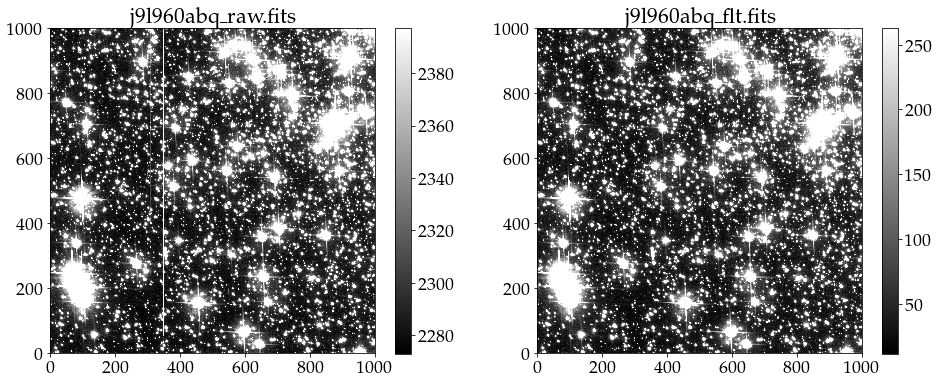

In [12]:
from astropy.visualization import ZScaleInterval
from astropy.visualization import ImageNormalize
from matplotlib import rc
import matplotlib.pyplot as plt

%matplotlib inline

# Update matplotlib settings to make plots more appealing.
rc('font',**{'family':'serif','serif':['Palatino'], 'size':18})
rc('text', usetex=True)

# Here we will define a function that does the image plotting
# and that we can call upon multiple times. The function will
# pull data from the first science extension, which for a full-frame
# ACS/WFC image corresponds to the WFC2 CCD, which uses readout
# amplifiers C and D.
def plot_image(fitsname, axis, figure, origin_y=0, origin_x=0, 
               ysize=200, xsize=200, scale=ZScaleInterval(),
               extension=1):
    with fits.open(fitsname) as hdu:
        fits_data = hdu[extension].data[origin_y: origin_y + ysize, 
                                        origin_x: origin_x + xsize]
        
        norm_image = ImageNormalize(fits_data, interval=scale)
        
        img = axis.imshow(fits_data, cmap='gray', origin='lower', norm=norm_image)
        
        figure.colorbar(img, ax=axis)
        
        # Because we have TeX rendering turned on, we need to escape the underscore
        # in the file name.
        axis.set_title(fitsname.replace('_', '\_'))

# Define the figure.
fig = plt.figure(figsize=(16, 6))

# Plot the *_raw.fits file example. Remember to adjust the x and y
# positions of the origin to accomodate the prescan/overscan regions.
ax1 = fig.add_subplot(1, 2, 1)
plot_image('j9l960abq_raw.fits', ax1, fig, origin_y=500, origin_x=24, ysize=1000, xsize=1000)

# Plot the *_flt.fits file example. The x position of the origin is
# set to 0, while the y origin begins at row 500.
ax2 = fig.add_subplot(1, 2, 2)
plot_image('j9l960abq_flt.fits', ax2, fig, origin_y=500, origin_x=0, ysize=1000, xsize=1000)

# If an FLC file was made, plot part of the FLT and FLC files to compare
# the CTE correction. By using the first science extention, setting 
# the x and y positions of the origin to 924, and setting the size to 200, 
# we will get a 200 x 200 pixel cutout centered on (1024, 1024) in the 
# center of the readout amplifier C region.
if os.path.exists('j9l960abq_flc.fits'):
    fig = plt.figure(figsize=(16, 6))
    
    ax1 = fig.add_subplot(1, 2, 1)
    plot_image('j9l960abq_flt.fits', ax1, origin_y=924, origin_x=924, ysize=200, xsize=200)

    ax2 = fig.add_subplot(1, 2, 1)
    plot_image('j9l960abq_flc.fits', ax1, origin_y=924, origin_x=924, ysize=200, xsize=200)

Comparing the FLT calibrated image to the RAW uncalibrated one, we can see that image artifacts have been removed. Most noticeably, hot columns in the bias have been subtracted. This image was taken prior to SM4, however post-SM4 images would show horizontal stripes in the RAW image, which are removed by `calacs` in the creation of the FLT/FLC images. Both images have been displayed using ZScale scaling, and examining the colorbars show that the FLT image has fewer counts per pixel primarily due to the removal of the bias and dark current. Also note that the image units have changed: RAW ACS images have units of DN, while FLT/FLC images have units of electrons.

The FLT and FLC images are not yet suitable for photometry. Before performing any analysis on the images, we still need to remove detector artifacts, cosmic rays, and geometric distortion. [AstroDrizzle](http://drizzlepac.stsci.edu) can be used to do all of these steps and produce a single mosaic image that incorporates all of the individual exposures.

# 4. Align and Combine Calibrated Images with AstroDrizzle

>In this part, we will show you how to:
>
>1. Update the FLT/FLC file WCS header keywords
>2. Align individual images to a reference image
>3. Combine individual images into a mosaic suitable for photometry

Now that we have created calibrated files from the raw data, we can use [AstroDrizzle](http://drizzlepac.stsci.edu) to astrometrically align our several individual images and create a combined mosaic free of geometric distortion. For detailed information on how the drizzling process works, users are encouraged to read the [AstroDrizzle](http://drizzlepac.stsci.edu) documentation.

### 4.1 Image Alignment

To begin, we need to run `stwcs.updatewcs` on the individual files to update the header keywords to do with the astrometry.

<div class="alert alert-block alert-info"><p><b>Note:</b> The Astrometry Working Group at STScI has recently added absolute astrometry solutions as part of the stwcs.updatewcs functionality. Data processed with calacs v10.0.0 and later will attempt to query AstrometryDB through MAST. The astrometry database is not yet available, which will print a scary warning to the screen. This has no detrimental affect to your data.</p>

<p>In the interim, users interested in improving the absolute astrometry of their observations should consult Varun Bajaj's in-depth guide to astrometric alignment with the GAIA catalog using tweakreg. For more information, see his publication [WFC3 ISR 2017-19](http://www.stsci.edu/hst/wfc3/documents/ISRs/WFC3-2017-19.pdf) and a jupyter notebook at the [gaia_alignment](https://github.com/spacetelescope/gaia_alignment) GitHub repository. More information about the *HST* astrometric accuracy compared to GAIA can be found in [ACS ISR 2018-01](http://www.stsci.edu/hst/acs/documents/isrs/isr1801.pdf) by Kozhurina-Platais, Grogin, & Sabbi.</p></div>

In [7]:
from stwcs import updatewcs

img_files = 'j9l9*_flt.fits'
# img_files = 'j9l9*_flc.fits

updatewcs.updatewcs(img_files, use_db=False)

<html xmlns="http://www.w3.org/1999/xhtml">
<head>
<meta http-equiv="Content-Type" content="text/html; charset=iso-8859-1"/>
<title>401 - Unauthorized: Access is denied due to invalid credentials.</title>
<style type="text/css">
<!--
body{margin:0;font-size:.7em;font-family:Verdana, Arial, Helvetica, sans-serif;background:#EEEEEE;}
fieldset{padding:0 15px 10px 15px;} 
h1{font-size:2.4em;margin:0;color:#FFF;}
h2{font-size:1.7em;margin:0;color:#CC0000;} 
h3{font-size:1.2em;margin:10px 0 0 0;color:#000000;} 
#header{width:96%;margin:0 0 0 0;padding:6px 2% 6px 2%;font-family:"trebuchet MS", Verdana, sans-serif;color:#FFF;
background-color:#555555;}
#content{margin:0 0 0 2%;position:relative;}
.content-container{background:#FFF;width:96%;margin-top:8px;padding:10px;position:relative;}
-->
</style>
</head>
<body>
<div id="header"><h1>Server Error</h1></div>
<div id="content">
 <div class="content-container"><fieldset>
  <h2>401 - Unauthorized: Access is denied due to invalid credentials.</h2

Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W


Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W


INFO:stwcs.updatewcs.astrometry_utils:Updating astrometry for j9l960a9q


Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W


INFO:stwcs.updatewcs.astrometry_utils:Updating astrometry for j9l960abq


Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W


INFO:stwcs.updatewcs.astrometry_utils:Updating astrometry for j9l960adq


Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 444 for chip 2 : F606W
Using 2015-calibrated VAFACTOR-corrected TDD correction...
- IDCTAB: Distortion model from row 443 for chip 1 : F606W


INFO:stwcs.updatewcs.astrometry_utils:Updating astrometry for j9l960afq


['j9l960a9q_flt.fits',
 'j9l960abq_flt.fits',
 'j9l960adq_flt.fits',
 'j9l960afq_flt.fits']

The next step is to use `drizzlepac.tweakreg` to improve the alignment between multiple images. This matches unresolved sources in the images to create a transformation for each image relative to a reference image. The offsets computed by `drizzlepac.tweakreg` can be saved to an output file for inspection. Sources used for alignment should be reasonably bright, but not near saturation. Too many sources do not necessarily yield a better transformation, while too few sources make finding a transformation solution difficult. We can run `drizzlepac.tweakreg` to both the FLT and the FLC files (if they were made) in one step.

We have chosen `j9l960abq_flt.fits` to be our reference image, and because we want a reference catalog of well-detected sources, we have set the minimum signal-to-noise for sources to be 4,000. The `dqbits` parameter allows us to only examine pixels with a value of 0 ("good") in the data quality array. We have also placed a restriction that the peak pixel value in a source must be less than 50,000 electrons (above this value, pixels are nearing the full-well saturation). Finally, we have chosen a convolution kernel width of 3.5 pixels, which is appropriate for ACS/WFC and WFC3/UVIS.

The following task in the stsci.skypac package can be run with TEAL:
                                    skymatch                                    
The following tasks in the drizzlepac package can be run with TEAL:
    astrodrizzle       imagefindpars           mapreg              photeq       
     pixreplace           pixtopix            pixtosky        refimagefindpars  
     resetbits          runastrodriz          skytopix           tweakback      
      tweakreg           updatenpol


INFO:drizzlepac.util:Setting up logfile :  tweakreg.log


Setting up logfile :  tweakreg.log


INFO:drizzlepac.util:


INFO:drizzlepac.tweakreg:TweakReg Version 1.4.5(7-Oct-2017) started at: 20:02:46.856 (29/03/2018)


TweakReg Version 1.4.5(7-Oct-2017) started at: 20:02:46.856 (29/03/2018)


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.util:Version Information


Version Information


INFO:drizzlepac.util:


INFO:drizzlepac.util:--------------------


--------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10)


Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10)


INFO:drizzlepac.util:[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]


INFO:drizzlepac.util:


INFO:drizzlepac.util:numpy Version -> 1.13.1 


numpy Version -> 1.13.1 


INFO:drizzlepac.util:


INFO:drizzlepac.util:astropy Version -> 2.0.2 


astropy Version -> 2.0.2 


INFO:drizzlepac.util:


INFO:drizzlepac.util:stwcs Version -> 1.4.0 


stwcs Version -> 1.4.0 


INFO:drizzlepac.util:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	exclusions :	
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	input :	j9l9*_flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	refimage :	j9l960abq_flt.fits
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	updatewcs :	False
INFO:drizzlepac.tweakreg:	verbose :	False
INFO:drizzlepac.tweakreg:	writecat :	True
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Finding shifts for: 


Finding shifts for: 


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:    j9l960a9q_flt.fits


    j9l960a9q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:    j9l960abq_flt.fits


    j9l960abq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:    j9l960adq_flt.fits


    j9l960adq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:    j9l960afq_flt.fits


    j9l960afq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for each input image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	0
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	j9l9*_flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	50000
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	j9l960abq_flt.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0
IN

===  Source finding for image 'j9l960a9q_flt.fits':


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960a9q_flt.fits', EXT=('SCI', 1) started at: 20:02:47.644 (29/03/2018)


  #  Source finding for 'j9l960a9q_flt.fits', EXT=('SCI', 1) started at: 20:02:47.644 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.112310
INFO:drizzlepac.catalogs:###Source finding finished at: 20:02:49.793 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 15699 objects.


     Found 15699 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960a9q_flt.fits', EXT=('SCI', 2) started at: 20:02:50.240 (29/03/2018)


  #  Source finding for 'j9l960a9q_flt.fits', EXT=('SCI', 2) started at: 20:02:50.240 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.828239
INFO:drizzlepac.catalogs:###Source finding finished at: 20:02:52.398 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 17519 objects.


     Found 17519 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j9l960a9q_flt.fits': 33218


===  FINAL number of objects in image 'j9l960a9q_flt.fits': 33218


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j9l960abq_flt.fits':


===  Source finding for image 'j9l960abq_flt.fits':


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 1) started at: 20:02:53.252 (29/03/2018)


  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 1) started at: 20:02:53.252 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.430332
INFO:drizzlepac.catalogs:###Source finding finished at: 20:02:55.295 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 16195 objects.


     Found 16195 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 2) started at: 20:02:55.690 (29/03/2018)


  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 2) started at: 20:02:55.690 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.553573
INFO:drizzlepac.catalogs:###Source finding finished at: 20:02:58.001 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 16742 objects.


     Found 16742 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j9l960abq_flt.fits': 32937


===  FINAL number of objects in image 'j9l960abq_flt.fits': 32937


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j9l960adq_flt.fits':


===  Source finding for image 'j9l960adq_flt.fits':


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960adq_flt.fits', EXT=('SCI', 1) started at: 20:02:58.867 (29/03/2018)


  #  Source finding for 'j9l960adq_flt.fits', EXT=('SCI', 1) started at: 20:02:58.867 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.501913
INFO:drizzlepac.catalogs:###Source finding finished at: 20:03:01.074 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 17131 objects.


     Found 17131 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960adq_flt.fits', EXT=('SCI', 2) started at: 20:03:01.412 (29/03/2018)


  #  Source finding for 'j9l960adq_flt.fits', EXT=('SCI', 2) started at: 20:03:01.412 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.916443
INFO:drizzlepac.catalogs:###Source finding finished at: 20:03:03.181 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 15517 objects.


     Found 15517 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j9l960adq_flt.fits': 32648


===  FINAL number of objects in image 'j9l960adq_flt.fits': 32648


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:===  Source finding for image 'j9l960afq_flt.fits':


===  Source finding for image 'j9l960afq_flt.fits':


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960afq_flt.fits', EXT=('SCI', 1) started at: 20:03:03.885 (29/03/2018)


  #  Source finding for 'j9l960afq_flt.fits', EXT=('SCI', 1) started at: 20:03:03.885 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.255091
INFO:drizzlepac.catalogs:###Source finding finished at: 20:03:05.584 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 18223 objects.


     Found 18223 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960afq_flt.fits', EXT=('SCI', 2) started at: 20:03:05.906 (29/03/2018)


  #  Source finding for 'j9l960afq_flt.fits', EXT=('SCI', 2) started at: 20:03:05.906 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 8.751761
INFO:drizzlepac.catalogs:###Source finding finished at: 20:03:07.44 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 15768 objects.


     Found 15768 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j9l960afq_flt.fits': 33991


===  FINAL number of objects in image 'j9l960afq_flt.fits': 33991


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for finding sources for the reference image:
INFO:drizzlepac.tweakreg:	clean :	False
INFO:drizzlepac.tweakreg:	computesig :	True
INFO:drizzlepac.tweakreg:	conv_width :	3.5
INFO:drizzlepac.tweakreg:	dqbits :	0
INFO:drizzlepac.tweakreg:	enforce_user_order :	False
INFO:drizzlepac.tweakreg:	expand_refcat :	False
INFO:drizzlepac.tweakreg:	fluxmax :	None
INFO:drizzlepac.tweakreg:	fluxmin :	None
INFO:drizzlepac.tweakreg:	input :	j9l9*_flt.fits
INFO:drizzlepac.tweakreg:	interactive :	False
INFO:drizzlepac.tweakreg:	nsigma :	1.5
INFO:drizzlepac.tweakreg:	peakmax :	50000
INFO:drizzlepac.tweakreg:	peakmin :	None
INFO:drizzlepac.tweakreg:	ratio :	1.0
INFO:drizzlepac.tweakreg:	refimage :	j9l960abq_flt.fits
INFO:drizzlepac.tweakreg:	roundhi :	1.0
INFO:drizzlepac.tweakreg:	roundlo :	-1.0
INFO:drizzlepac.tweakreg:	runfile :	tweakreg.log
INFO:drizzlepac.tweakreg:	sharphi :	1.0
INFO:drizzlepac.tweakreg:	sharplo :	0.2
INFO:drizzlepac.tweakreg:	skysigma :	0.0

===  Source finding for image 'j9l960abq_flt.fits':


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 1) started at: 20:03:08.20 (29/03/2018)


  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 1) started at: 20:03:08.20 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.430332
INFO:drizzlepac.catalogs:###Source finding finished at: 20:03:09.192 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 2709 objects.


     Found 2709 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 2) started at: 20:03:09.370 (29/03/2018)


  #  Source finding for 'j9l960abq_flt.fits', EXT=('SCI', 2) started at: 20:03:09.370 (29/03/2018)


INFO:drizzlepac.catalogs:


INFO:drizzlepac.catalogs:   Finding sources using sky sigma = 9.553573
INFO:drizzlepac.catalogs:###Source finding finished at: 20:03:10.246 (29/03/2018)
INFO:drizzlepac.catalogs:     Found 2796 objects.


     Found 2796 objects.


INFO:drizzlepac.catalogs:


INFO:drizzlepac.imgclasses:===  FINAL number of objects in image 'j9l960abq_flt.fits': 5505


===  FINAL number of objects in image 'j9l960abq_flt.fits': 5505


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:


Reference image contains a distorted WCS.
Using the undistorted version of this WCS.

INFO:drizzlepac.imgclasses:Converting RA/Dec positions of reference sources from "j9l960abq_flt.fits" to X,Y positions in reference WCS...
INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:Performing alignment in the projection plane defined by the WCS


Performing alignment in the projection plane defined by the WCS


INFO:drizzlepac.tweakreg:derived from 'j9l960abq_flt.fits'


derived from 'j9l960abq_flt.fits'


INFO:drizzlepac.tweakreg:===============================================================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for matching sources:
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	searchrad :	1.0
INFO:drizzlepac.tweakreg:	searchunits :	arcseconds
INFO:drizzlepac.tweakreg:	see2dplot :	True
INFO:drizzlepac.tweakreg:	separation :	0.5
INFO:drizzlepac.tweakreg:	tolerance :	1.0
INFO:drizzlepac.tweakreg:	use2dhist :	True
INFO:drizzlepac.tweakreg:	xoffset :	0.0
INFO:drizzlepac.tweakreg:	yoffset :	0.0
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for fitting source lists:
INFO:drizzlepac.tweakreg:	fitgeometry :	rscale
INFO:drizzlepac.tweakreg:	labelsize :	8
INFO:drizzlepac.tweakreg:	minobj :	15
INFO:drizzlepac.tweakreg:	nclip :	3
INFO:drizzlepac.tweakreg:	residplot :	both
INFO:drizzlepac.tweakreg:	sigma :	3.0
INFO:drizzlepac.tweakreg:	ylimit :	None
INFO:drizzlepac.tweakreg:USER INPUT PARAMETERS for creating a shiftfile:
INFO:drizzlepac.tweakreg:	outshifts :	shifts.txt
INFO:drizzlepac.tweakreg:	out

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Performing fit for: j9l960a9q_flt.fits


Performing fit for: j9l960a9q_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j9l960a9q_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


Matching sources from 'j9l960a9q_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.208156897704 -0.01069757076


Found initial X and Y shifts of  -0.208156897704 -0.01069757076


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:    with significance of  4939.22493636 and  3016.0  matches


    with significance of  4939.22493636 and  3016.0  matches


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.imgclasses:Found 4211 matches for j9l960a9q_flt.fits...


Found 4211 matches for j9l960a9q_flt.fits...


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j9l960a9q_flt.fits : 


Computed  rscale  fit for  j9l960a9q_flt.fits : 


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:XSH: 0.0294  YSH: 0.0947    ROT: 359.9997473    SCALE: 0.999998


XSH: 0.0294  YSH: 0.0947    ROT: 359.9997473    SCALE: 0.999998


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:XRMS: 0.037    YRMS: 0.034


XRMS: 0.037    YRMS: 0.034


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2e-06 (deg)   RMS_DEC: 3.4e-07 (deg)


RMS_RA: 2e-06 (deg)   RMS_DEC: 3.4e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  3674  objects.


Final solution based on  3674  objects.


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j9l960a9q_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j9l960a9q_flt_catalog_fit.match


wrote XY data to:  j9l960a9q_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Total # points:  3674


Total # points:  3674


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:# of points after clipping:  3674


# of points after clipping:  3674


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Total # points:  3674


Total # points:  3674


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:# of points after clipping:  3674


# of points after clipping:  3674


INFO:drizzlepac.tweakutils:


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  j9l960a9q_flt.fits
INFO:stwcs.wcsutil.wcscorr:
INFO:astropy:
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please appe

INFO:drizzlepac.updatehdr:....Updating header for j9l960a9q_flt.fits...


....Updating header for j9l960a9q_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j9l960a9q_flt.fits['SCI',1]


Processing j9l960a9q_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j9l960a9q_flt.fits[1]


Updating header for j9l960a9q_flt.fits[1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 1.3531663633035677e-05 3.9037411548943393e-06
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 2.9430944660513258e-06 -1.341949465161363e-05
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRVAL    : 6.0107161832612928 -72.065494036055014
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049852789312619682
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 163.78024653784414
INFO:stwcs.wcsutil.hstwcs:
INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j9l960a9q_flt.fits['SCI',2]


Processing j9l960a9q_flt.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j9l960a9q_flt.fits[4]


Updating header for j9l960a9q_flt.fits[4]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 1.3410018124955999e-05 3.8781935143293979e-06
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 2.7352957398510705e-06 -1.2940936761328123e-05
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRVAL    : 6.0371441227996057 -72.093209542527134
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049270013665327649
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 163.31736032801427
INFO:stwcs.wcsutil.hstwcs:
INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Performing fit for: j9l960abq_flt.fits


Performing fit for: j9l960abq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j9l960abq_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


Matching sources from 'j9l960abq_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:NO fit performed for reference image: j9l960abq_flt.fits

INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  j9l960abq_flt.fits
INFO:stwcs.wcsutil.wcscorr:
INFO:astropy:
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being app

INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Performing fit for: j9l960adq_flt.fits


Performing fit for: j9l960adq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j9l960adq_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


Matching sources from 'j9l960adq_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.928459995543 -0.946735012258


Found initial X and Y shifts of  -0.928459995543 -0.946735012258


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:    with significance of  9459.89368933 and  3902.0  matches


    with significance of  9459.89368933 and  3902.0  matches


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.imgclasses:Found 4216 matches for j9l960adq_flt.fits...


Found 4216 matches for j9l960adq_flt.fits...


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j9l960adq_flt.fits : 


Computed  rscale  fit for  j9l960adq_flt.fits : 


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:XSH: -0.0914  YSH: -0.1316    ROT: 0.0005577418062    SCALE: 0.999999


XSH: -0.0914  YSH: -0.1316    ROT: 0.0005577418062    SCALE: 0.999999


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:XRMS: 0.037    YRMS: 0.035


XRMS: 0.037    YRMS: 0.035


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2e-06 (deg)   RMS_DEC: 3.5e-07 (deg)


RMS_RA: 2e-06 (deg)   RMS_DEC: 3.5e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  3697  objects.


Final solution based on  3697  objects.


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j9l960adq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j9l960adq_flt_catalog_fit.match


wrote XY data to:  j9l960adq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Total # points:  3697


Total # points:  3697


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:# of points after clipping:  3697


# of points after clipping:  3697


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Total # points:  3697


Total # points:  3697


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:# of points after clipping:  3697


# of points after clipping:  3697


INFO:drizzlepac.tweakutils:


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  j9l960adq_flt.fits
INFO:stwcs.wcsutil.wcscorr:
INFO:astropy:
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please appe

INFO:drizzlepac.updatehdr:....Updating header for j9l960adq_flt.fits...


....Updating header for j9l960adq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j9l960adq_flt.fits['SCI',1]


Processing j9l960adq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j9l960adq_flt.fits[1]


Updating header for j9l960adq_flt.fits[1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 1.3531837413724648e-05 3.9024334583168709e-06
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 2.9417836132899924e-06 -1.341976073295503e-05
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRVAL    : 6.0058469547665814 -72.068257396913936
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049852457094735521
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 163.78569899234722
INFO:stwcs.wcsutil.hstwcs:
INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j9l960adq_flt.fits['SCI',2]


Processing j9l960adq_flt.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j9l960adq_flt.fits[4]


Updating header for j9l960adq_flt.fits[4]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 1.3410173277068953e-05 3.8769306406210271e-06
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 2.7339971823625756e-06 -1.2941204439953234e-05
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRVAL    : 6.0322700531607598 -72.095973459810494
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049269685360642891
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 163.32281684246996
INFO:stwcs.wcsutil.hstwcs:
INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:====================


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.tweakreg:Performing fit for: j9l960afq_flt.fits


Performing fit for: j9l960afq_flt.fits


INFO:drizzlepac.tweakreg:


INFO:drizzlepac.imgclasses:Matching sources from 'j9l960afq_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


Matching sources from 'j9l960afq_flt.fits' with sources from reference image 'j9l960abq_flt.fits'


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.tweakutils:Computing initial guess for X and Y shifts...


Computing initial guess for X and Y shifts...


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Found initial X and Y shifts of  -0.948694869487 -0.960396039604


Found initial X and Y shifts of  -0.948694869487 -0.960396039604


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:    with significance of  12931.1838987 and  4026.0  matches


    with significance of  12931.1838987 and  4026.0  matches


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.imgclasses:Found 4197 matches for j9l960afq_flt.fits...


Found 4197 matches for j9l960afq_flt.fits...


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.linearfit:Performing "rscale" fit
INFO:drizzlepac.imgclasses:Computed  rscale  fit for  j9l960afq_flt.fits : 


Computed  rscale  fit for  j9l960afq_flt.fits : 


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:XSH: -0.1876  YSH: -0.2059    ROT: 0.0009443074571    SCALE: 1.000001


XSH: -0.1876  YSH: -0.2059    ROT: 0.0009443074571    SCALE: 1.000001


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:XRMS: 0.038    YRMS: 0.036


XRMS: 0.038    YRMS: 0.036


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:RMS_RA: 2e-06 (deg)   RMS_DEC: 3.6e-07 (deg)


RMS_RA: 2e-06 (deg)   RMS_DEC: 3.6e-07 (deg)


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Final solution based on  3679  objects.


Final solution based on  3679  objects.


INFO:drizzlepac.imgclasses:


INFO:drizzlepac.imgclasses:Creating catalog for the fit: j9l960afq_flt_catalog_fit.match
INFO:drizzlepac.tweakutils:wrote XY data to:  j9l960afq_flt_catalog_fit.match


wrote XY data to:  j9l960afq_flt_catalog_fit.match


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Total # points:  3679


Total # points:  3679


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:# of points after clipping:  3679


# of points after clipping:  3679


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:Total # points:  3679


Total # points:  3679


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.tweakutils:# of points after clipping:  3679


# of points after clipping:  3679


INFO:drizzlepac.tweakutils:


INFO:stwcs.wcsutil.wcscorr:Initializing new WCSCORR table for  j9l960afq_flt.fits
INFO:stwcs.wcsutil.wcscorr:
INFO:astropy:
                Inconsistent SIP distortion information is present in the FITS header and the WCS object:
                SIP coefficients were detected, but CTYPE is missing a "-SIP" suffix.
                astropy.wcs is using the SIP distortion coefficients,
                therefore the coordinates calculated here might be incorrect.

                If you do not want to apply the SIP distortion coefficients,
                please remove the SIP coefficients from the FITS header or the
                WCS object.  As an example, if the image is already distortion-corrected
                (e.g., drizzled) then distortion components should not apply and the SIP
                coefficients should be removed.

                While the SIP distortion coefficients are being applied here, if that was indeed the intent,
                for consistency please appe

INFO:drizzlepac.updatehdr:....Updating header for j9l960afq_flt.fits...


....Updating header for j9l960afq_flt.fits...


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j9l960afq_flt.fits['SCI',1]


Processing j9l960afq_flt.fits['SCI',1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j9l960afq_flt.fits[1]


Updating header for j9l960afq_flt.fits[1]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 1.3532098392522123e-05 3.9018194697378553e-06
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 2.9411557843752314e-06 -1.3420067156164592e-05
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRVAL    : 6.0034129084468892 -72.069638362237527
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049852993577908053
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 163.78846678539372
INFO:stwcs.wcsutil.hstwcs:
INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Processing j9l960afq_flt.fits['SCI',2]


Processing j9l960afq_flt.fits['SCI',2]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:Updating header for j9l960afq_flt.fits[4]


Updating header for j9l960afq_flt.fits[4]


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.updatehdr:    with WCS of
INFO:stwcs.wcsutil.hstwcs:WCS Keywords
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_11  CD_12: 1.3410423249103526e-05 3.8763390698469336e-06
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CD_21  CD_22: 2.73337289758234e-06 -1.2941505516053439e-05
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRVAL    : 6.0298338551275004 -72.097355061446123
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:CRPIX    : 2048.0 1024.0
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:NAXIS    : 4096 2048
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:Plate Scale : 0.049270215565123093
INFO:stwcs.wcsutil.hstwcs:
INFO:stwcs.wcsutil.hstwcs:ORIENTAT : 163.32558667827607
INFO:stwcs.wcsutil.hstwcs:
INFO:drizzlepac.updatehdr:WCSNAME  :  TWEAK


WCSNAME  :  TWEAK


INFO:drizzlepac.updatehdr:


INFO:drizzlepac.imgclasses:    Writing out new WCS to alternate WCS: "B"
INFO:drizzlepac.imgclasses:Updating WCSCORR table with new WCS solution "TWEAK"
  keyword), VerifyWarning)

  keyword), VerifyWarning)

INFO:drizzlepac.tweakutils:Writing out shiftfile : shifts.txt


Writing out shiftfile : shifts.txt


INFO:drizzlepac.tweakutils:


INFO:drizzlepac.util:Trailer file written to:  tweakreg.log


Trailer file written to:  tweakreg.log


INFO:drizzlepac.util:


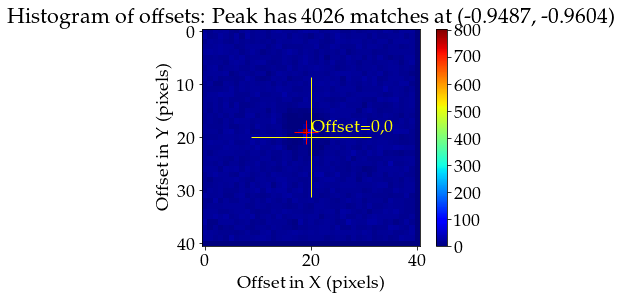

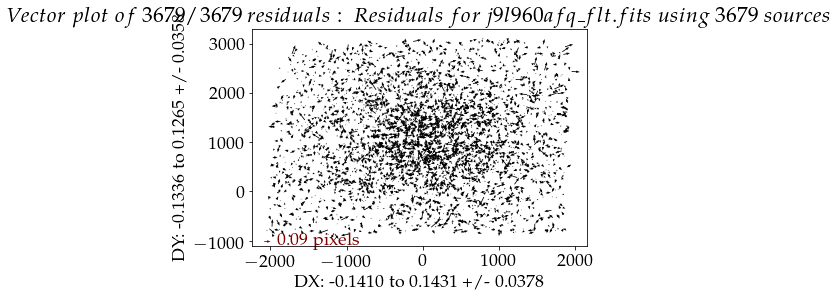

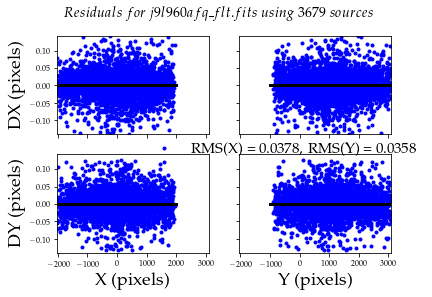

In [8]:
from drizzlepac import tweakreg

tweakreg.TweakReg(img_files, shiftfile=True, interactive=False, 
                  expand_refcat=False, refimage='j9l960abq_flt.fits', 
                  updatehdr=True, 
                  imagefindcfg={'dqbits': 0, 'threshold': 1000, 
                                'peakmax': 50000, 'conv_width': 3.5},
                  refimagefindcfg={'dqbits': 0, 'threshold': 4000, 
                                   'peakmax': 50000, 'conv_width': 3.5})

### 4.2 Combining Images into a Single Mosaic

Now that the relative astrometry has been perfected, we can move on to combining the individual images into a single mosaic. In our call to AstroDrizzle below, we have adjusted some of the default parameters. Let us consider some of the parameters we have adjusted:

* **`driz_sep_bits`** and **`final_bits`**: These control the data quality bit flags that we will consider to be good when correcting individual frames and making the combined mosaic. ACS dark reference files are analyzed for pixel stability (see [ACS ISR 2017-05](http://www.stsci.edu/hst/acs/documents/isrs/isr1705.pdf)), and only *unstable* pixels are considered bad. Data quality flags 16 (hot pixels) and 64 (warm pixels) can be included in our analysis, while flag 32 (unstable pixels) should be excluded. We have also included flag 256 (saturation) in our combined product as pixels that have exceeded the full-well saturation can still be used for photometry (see ACS ISR ????-??). Pixels that exceed the A-to-D saturation (flag 2048) are still excluded.


* **`final_rot`**: Setting this to 0 will align our mosaic image such that North is along the positive y-axis and East is along the negative x-axis.


* **`final_wht_type`**: We have selected the exposure time ("EXP") weighting, which is appropriate for use with both Source Extractor and `photutils` photometry. The weight method selection depends strongly on both your data and analysis plan. See the [AstroDrizzle](http://drizzlepac.stsci.edu) documentation for more information.


* **`final_scale`**: This parameter controls the size of the output image pixels and has units of arcseconds per pixel. A value of 0.03 is suitable for ACS/WFC.

In [9]:
from drizzlepac import astrodrizzle

astrodrizzle.AstroDrizzle(img_files, output='47tuc_f606w_1.0', 
                          driz_sep_bits='16, 64, 256', final_bits='16, 64, 256', 
                          final_wht_type='EXP', final_rot=0, final_scale=0.03, 
                          final_pixfrac=1.0)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


INPUT_DICT: {'final_wht_type': 'EXP', 'final_scale': 0.03, 'final_rot': 0, 'final_bits': '16, 64, 256', 'output': '47tuc_f606w_1.0', 'final_pixfrac': 1.0, 'driz_sep_bits': '16, 64, 256', 'input': 'j9l9*_flt.fits'}
Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:04:04.090 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:04:04.090 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:04:04.099 (29/03/2018)


==== Processing Step  Initialization  started at  20:04:04.099 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Preserving original of:  j9l960a9q_flt.fits as  OrIg_files/j9l960a9q_flt.fits


Preserving original of:  j9l960a9q_flt.fits as  OrIg_files/j9l960a9q_flt.fits


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:Preserving original of:  j9l960abq_flt.fits as  OrIg_files/j9l960abq_flt.fits


Preserving original of:  j9l960abq_flt.fits as  OrIg_files/j9l960abq_flt.fits


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:Preserving original of:  j9l960adq_flt.fits as  OrIg_files/j9l960adq_flt.fits


Preserving original of:  j9l960adq_flt.fits as  OrIg_files/j9l960adq_flt.fits


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:Preserving original of:  j9l960afq_flt.fits as  OrIg_files/j9l960afq_flt.fits


Preserving original of:  j9l960afq_flt.fits as  OrIg_files/j9l960afq_flt.fits


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_1.0_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960a9q_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960a9q_flt.fits[DQ,2]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960abq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960abq_flt.fits[DQ,2]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960adq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960adq_flt.fits[DQ,2]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960afq_flt.fits[DQ,1]
INFO:drizzlepac.resetbits:Reset bit values of 4096 to a value of 0 in j9l960afq_flt.fits[DQ,2]
INFO:drizzlepac.processInpu

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 7963 Mb.


*  Estimated memory usage:  up to 7963 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         8


*  Cores available:         8


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:04:08.745 (29/03/2018)


==== Processing Step  Initialization  finished at  20:04:08.745 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_1.0
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	4096
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:04:08.775 (29/03/2018)


==== Processing Step  Static Mask  started at  20:04:08.775 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:04:11.836 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:04:11.840 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:04:11.840 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:USER INPUT PARAMETERS for Sky Subtraction Step:
INFO:drizzlepac.sky:	sky_bits :	0
INFO:drizzlepac.sky:	skyclip :	5
INFO:drizzlepac.sky:	skyfile :	
INFO:drizzlepac.sky:	skylower :	None
INFO:drizzlepac.sky:	skylsigma :	4.0
INFO:drizzlepac.sky:	skymask_cat :	
INFO:drizzlepac.sky:	skymethod :	localmin
INFO:drizzlepac.sky:	skystat :	median
INFO:drizzlepac.sky:	skysub :	True
INFO:drizzlepac.sky:	skyupper :	None
INFO:drizzlepac.sky:	skyuser :	
INFO:drizzlepac.sky:	skyusigma :	4.0
INFO:drizzlepac.sky:	skywidth :	0.1
INFO:drizzlepac.sky:	use_static :	True
INFO:stsci.skypac.utils:***** skymatch started on 2018-03-29 20:04:13.459100
INFO:stsci.skypac.utils:      Version 0.9.8 (25-October-2017)
INFO:stsci.skypac.utils:
INFO:stsci.skypac.utils:'skymatch' task will apply computed sky differences to input image file(s).
INFO:stsci.skypac.utils:
INFO:stsci.skypac.utils:NOTE: Computed sky values WILL NOT be subtracted from image data ('subtractsky'=False).
INFO:stsci.skypac.utils:'M

==== Processing Step  Subtract Sky  finished at  20:04:19.156 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:04:19.160 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:04:19.160 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=True as:
{'stepsize': 10, 'coeffs': True, 'bits': 336, 'compress': False, 'units': 'cps', 'wt_scl': 'exptime', 'kernel': 'turbo', 'wcskey': '', 'build': False, 'fillval': None, 'pixfrac': 1.0}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Separate Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	compress :	False
INFO:drizzlepac.adrizzle:	crbit :	None
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	turbo
INFO:drizzlepac.adrizzle:	num_cores :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	electrons
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	None
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzl

-Generating simple FITS output: j9l960abq_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960a9q_single_sci.fits


-Generating simple FITS output: j9l960a9q_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960adq_single_sci.fits


-Generating simple FITS output: j9l960adq_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960afq_single_sci.fits


-Generating simple FITS output: j9l960afq_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960abq_single_sci.fits


Writing out image to disk: j9l960abq_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960a9q_single_sci.fits


Writing out image to disk: j9l960a9q_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960adq_single_sci.fits


Writing out image to disk: j9l960adq_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960afq_single_sci.fits


Writing out image to disk: j9l960afq_single_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960abq_single_wht.fits


Writing out image to disk: j9l960abq_single_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960a9q_single_wht.fits


Writing out image to disk: j9l960a9q_single_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960adq_single_wht.fits


Writing out image to disk: j9l960adq_single_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960afq_single_wht.fits


Writing out image to disk: j9l960afq_single_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:04:25.88 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:04:25.88 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:04:25.897 (29/03/2018)


==== Processing Step  Create Median  started at  20:04:25.897 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:USER INPUT PARAMETERS for Create Median Step:
INFO:drizzlepac.createMedian:	combine_bufsize :	None
INFO:drizzlepac.createMedian:	combine_grow :	1
INFO:drizzlepac.createMedian:	combine_hthresh :	None
INFO:drizzlepac.createMedian:	combine_lthresh :	None
INFO:drizzlepac.createMedian:	combine_maskpt :	0.3
INFO:drizzlepac.createMedian:	combine_nhigh :	0
INFO:drizzlepac.createMedian:	combine_nlow :	0
INFO:drizzlepac.createMedian:	combine_nsigma :	4 3
INFO:drizzlepac.createMedian:	combine_type :	minmed
INFO:drizzlepac.createMedian:	compress :	False
INFO:drizzlepac.createMedian:	median :	True
INFO:drizzlepac.createMedian:	median_newmasks :	True
INFO:drizzlepac.createMedian:	proc_unit :	native
INFO:drizzlepac.createMedian:reference sky value for image  j9l960a9q_flt.fits  is  98.1074829102


reference sky value for image  j9l960a9q_flt.fits  is  98.1074829102


INFO:drizzlepac.createMedian:


INFO:drizzlepac.createMedian:reference sky value for image  j9l960abq_flt.fits  is  106.447753906


reference sky value for image  j9l960abq_flt.fits  is  106.447753906


INFO:drizzlepac.createMedian:


INFO:drizzlepac.createMedian:reference sky value for image  j9l960adq_flt.fits  is  108.220458984


reference sky value for image  j9l960adq_flt.fits  is  108.220458984


INFO:drizzlepac.createMedian:


INFO:drizzlepac.createMedian:reference sky value for image  j9l960afq_flt.fits  is  95.3567504883


reference sky value for image  j9l960afq_flt.fits  is  95.3567504883


INFO:drizzlepac.createMedian:


INFO:drizzlepac.createMedian:


INFO:drizzlepac.createMedian:


INFO:drizzlepac.createMedian:Saving output median image to:  47tuc_f606w_1.0_med.fits


Saving output median image to:  47tuc_f606w_1.0_med.fits


INFO:drizzlepac.createMedian:


INFO:drizzlepac.util:==== Processing Step  Create Median  finished at  20:04:35.605 (29/03/2018)


==== Processing Step  Create Median  finished at  20:04:35.605 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:04:35.608 (29/03/2018)


==== Processing Step  Blot  started at  20:04:35.608 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:USER INPUT PARAMETERS for Blot Step:
INFO:drizzlepac.ablot:	blot_addsky :	True
INFO:drizzlepac.ablot:	blot_interp :	poly5
INFO:drizzlepac.ablot:	blot_sinscl :	1.0
INFO:drizzlepac.ablot:	blot_skyval :	0.0
INFO:drizzlepac.ablot:	coeffs :	True
INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960a9q_flt.fits[sci,1]


    Blot: creating blotted image:  j9l960a9q_flt.fits[sci,1]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 98.107483 to blotted image j9l960a9q_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960a9q_sci1_blt.fits


-Generating simple FITS output: j9l960a9q_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960a9q_sci1_blt.fits


Writing out image to disk: j9l960a9q_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960a9q_flt.fits[sci,2]


    Blot: creating blotted image:  j9l960a9q_flt.fits[sci,2]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 98.107483 to blotted image j9l960a9q_flt.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960a9q_sci2_blt.fits


-Generating simple FITS output: j9l960a9q_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960a9q_sci2_blt.fits


Writing out image to disk: j9l960a9q_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960abq_flt.fits[sci,1]


    Blot: creating blotted image:  j9l960abq_flt.fits[sci,1]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 106.447754 to blotted image j9l960abq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960abq_sci1_blt.fits


-Generating simple FITS output: j9l960abq_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960abq_sci1_blt.fits


Writing out image to disk: j9l960abq_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960abq_flt.fits[sci,2]


    Blot: creating blotted image:  j9l960abq_flt.fits[sci,2]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 106.447754 to blotted image j9l960abq_flt.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960abq_sci2_blt.fits


-Generating simple FITS output: j9l960abq_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960abq_sci2_blt.fits


Writing out image to disk: j9l960abq_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960adq_flt.fits[sci,1]


    Blot: creating blotted image:  j9l960adq_flt.fits[sci,1]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 108.220459 to blotted image j9l960adq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960adq_sci1_blt.fits


-Generating simple FITS output: j9l960adq_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960adq_sci1_blt.fits


Writing out image to disk: j9l960adq_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960adq_flt.fits[sci,2]


    Blot: creating blotted image:  j9l960adq_flt.fits[sci,2]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 108.220459 to blotted image j9l960adq_flt.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960adq_sci2_blt.fits


-Generating simple FITS output: j9l960adq_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960adq_sci2_blt.fits


Writing out image to disk: j9l960adq_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960afq_flt.fits[sci,1]


    Blot: creating blotted image:  j9l960afq_flt.fits[sci,1]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 95.356750 to blotted image j9l960afq_flt.fits[sci,1]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960afq_sci1_blt.fits


-Generating simple FITS output: j9l960afq_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960afq_sci1_blt.fits


Writing out image to disk: j9l960afq_sci1_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.ablot:    Blot: creating blotted image:  j9l960afq_flt.fits[sci,2]


    Blot: creating blotted image:  j9l960afq_flt.fits[sci,2]


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Using default C-based coordinate transformation...


Using default C-based coordinate transformation...


INFO:drizzlepac.ablot:


INFO:drizzlepac.ablot:Applying sky value of 95.356750 to blotted image j9l960afq_flt.fits[sci,2]
INFO:drizzlepac.outputimage:-Generating simple FITS output: j9l960afq_sci2_blt.fits


-Generating simple FITS output: j9l960afq_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: j9l960afq_sci2_blt.fits


Writing out image to disk: j9l960afq_sci2_blt.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:04:52.018 (29/03/2018)


==== Processing Step  Blot  finished at  20:04:52.018 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:04:52.023 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:04:52.023 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:USER INPUT PARAMETERS for Driz_CR Step:
INFO:drizzlepac.drizCR:	crbit :	4096
INFO:drizzlepac.drizCR:	driz_cr :	True
INFO:drizzlepac.drizCR:	driz_cr_corr :	False
INFO:drizzlepac.drizCR:	driz_cr_ctegrow :	0
INFO:drizzlepac.drizCR:	driz_cr_grow :	1
INFO:drizzlepac.drizCR:	driz_cr_scale :	1.2 0.7
INFO:drizzlepac.drizCR:	driz_cr_snr :	3.5 3.0
INFO:drizzlepac.drizCR:	inmemory :	False
INFO:drizzlepac.drizCR:Executing 4 parallel workers
INFO:drizzlepac.drizCR:Creating output :  j9l960adq_sci1_crmask.fits


Creating output :  j9l960adq_sci1_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.drizCR:Creating output :  j9l960abq_sci1_crmask.fits


Creating output :  j9l960abq_sci1_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.drizCR:Creating output :  j9l960afq_sci1_crmask.fits


Creating output :  j9l960afq_sci1_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.drizCR:Creating output :  j9l960a9q_sci1_crmask.fits


Creating output :  j9l960a9q_sci1_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.drizCR:Creating output :  j9l960adq_sci2_crmask.fits


Creating output :  j9l960adq_sci2_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.drizCR:Creating output :  j9l960abq_sci2_crmask.fits


Creating output :  j9l960abq_sci2_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.drizCR:Creating output :  j9l960afq_sci2_crmask.fits


Creating output :  j9l960afq_sci2_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.drizCR:Creating output :  j9l960a9q_sci2_crmask.fits


Creating output :  j9l960a9q_sci2_crmask.fits


INFO:drizzlepac.drizCR:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  finished at  20:04:58.125 (29/03/2018)


==== Processing Step  Driz_CR  finished at  20:04:58.125 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:04:58.137 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:04:58.137 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 1.0, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	1.0
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_1.0_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_1.0_drz_sci.fits


Writing out image to disk: 47tuc_f606w_1.0_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_1.0_drz_wht.fits


Writing out image to disk: 47tuc_f606w_1.0_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_1.0_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_1.0_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:05:48.030 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:05:48.030 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:05:48.035 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:05:48.035 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          4.6465 sec.


         Initialization          4.6465 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          3.0617 sec.


            Static Mask          3.0617 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          7.3159 sec.


           Subtract Sky          7.3159 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          6.7291 sec.


       Separate Drizzle          6.7291 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          9.7071 sec.


          Create Median          9.7071 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          16.4106 sec.


                   Blot          16.4106 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          6.1024 sec.


                Driz_CR          6.1024 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          49.8930 sec.


          Final Drizzle          49.8930 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          103.8664 sec.


                  Total          103.8664 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:


### 4.3 Optimizing the final_pixfrac Parameter

We now have a calibrated, cosmic-ray cleaned mosaic free of geometric distortion. However, we can make a better product that uses optimal parameters in [AstroDrizzle](http://drizzlepac.stsc.edu) to better sample the ACS/WFC PSF. In particular, we will test several values of the `final_pixfrac` parameter to make a better mosaic.

Note that in this call to [AstroDrizzle](http://drizzlepac.stsci.edu), we have turned off all steps other than the final image combination. We have also taken care to set the `resetbits` option to 0 so that we do not lose the cosmic ray rejection performed as part of the first time we ran AstroDrizzle.

In [10]:
import numpy

# Create an array of final_pixfrac values ranging from 0.1
# to 0.9 in steps of 0.1.
pixfracs = numpy.linspace(0.1, 0.9, 9)

# Loop over each final_pixfrac value, creating drizzled
# products with root file name "47tuc_f606w_XX" where
# XX is the final_pixfrac value.
for frac in pixfracs:
    astrodrizzle.AstroDrizzle(img_files, 
                              output='47tuc_f606w_' + str(frac), resetbits=0,
                              driz_sep_bits='16, 64, 256', final_bits='16, 64, 256',
                              final_wht_type='EXP', final_rot=0, final_scale=0.03, 
                              final_pixfrac=frac, skysub=False, driz_separate=False,
                              median=False, blot=False, driz_cr=False)

INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.10000000000000001, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.1', 'final_wht_type': 'EXP', 'skysub': False}
Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:07:56.491 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:07:56.491 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:07:56.502 (29/03/2018)


==== Processing Step  Initialization  started at  20:07:56.502 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.1_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:07:58.953 (29/03/2018)


==== Processing Step  Initialization  finished at  20:07:58.953 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.1
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:07:58.983 (29/03/2018)


==== Processing Step  Static Mask  started at  20:07:58.983 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:08:02.083 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:08:02.09 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:08:02.09 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:08:02.495 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:08:02.495 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:08:02.499 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:08:02.499 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:08:02.506 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:08:02.506 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:08:02.512 (29/03/2018)


==== Processing Step  Create Median  started at  20:08:02.512 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:08:02.518 (29/03/2018)


==== Processing Step  Blot  started at  20:08:02.518 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:08:02.526 (29/03/2018)


==== Processing Step  Blot  finished at  20:08:02.526 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:08:02.531 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:08:02.531 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:08:02.537 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:08:02.537 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.1, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.1
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_0.1_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.1_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.1_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.1_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.1_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.1_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.1_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:08:32.057 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:08:32.057 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:08:32.064 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:08:32.064 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.4510 sec.


         Initialization          2.4510 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          3.0998 sec.


            Static Mask          3.0998 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.4043 sec.


           Subtract Sky          0.4043 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0072 sec.


       Separate Drizzle          0.0072 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0081 sec.


                   Blot          0.0081 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          29.5200 sec.


          Final Drizzle          29.5200 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          35.4905 sec.


                  Total          35.4905 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:



INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.20000000000000001, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.2', 'final_wht_type': 'EXP', 'skysub': False}


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:08:32.305 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:08:32.305 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:08:32.318 (29/03/2018)


==== Processing Step  Initialization  started at  20:08:32.318 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.2_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:08:34.456 (29/03/2018)


==== Processing Step  Initialization  finished at  20:08:34.456 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.2
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:08:34.481 (29/03/2018)


==== Processing Step  Static Mask  started at  20:08:34.481 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:08:36.758 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:08:36.763 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:08:36.763 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:08:37.13 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:08:37.13 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:08:37.140 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:08:37.140 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:08:37.146 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:08:37.146 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:08:37.15 (29/03/2018)


==== Processing Step  Create Median  started at  20:08:37.15 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:08:37.156 (29/03/2018)


==== Processing Step  Blot  started at  20:08:37.156 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:08:37.162 (29/03/2018)


==== Processing Step  Blot  finished at  20:08:37.162 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:08:37.16 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:08:37.16 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:08:37.172 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:08:37.172 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.2, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.2
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_0.2_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.2_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.2_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.2_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.2_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.2_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.2_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:09:06.898 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:09:06.898 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:09:06.905 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:09:06.905 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.1380 sec.


         Initialization          2.1380 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          2.2771 sec.


            Static Mask          2.2771 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.3726 sec.


           Subtract Sky          0.3726 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0060 sec.


       Separate Drizzle          0.0060 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0054 sec.


                   Blot          0.0054 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          29.7262 sec.


          Final Drizzle          29.7262 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          34.5254 sec.


                  Total          34.5254 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.30000000000000004, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.3', 'final_wht_type': 'EXP', 'skysub': False}
Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:09:07.251 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:09:07.251 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:09:07.26 (29/03/2018)


==== Processing Step  Initialization  started at  20:09:07.26 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.3_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:09:10.212 (29/03/2018)


==== Processing Step  Initialization  finished at  20:09:10.212 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.3
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:09:10.238 (29/03/2018)


==== Processing Step  Static Mask  started at  20:09:10.238 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:09:13.518 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:09:13.522 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:09:13.522 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:09:14.048 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:09:14.048 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:09:14.053 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:09:14.053 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:09:14.060 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:09:14.060 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:09:14.065 (29/03/2018)


==== Processing Step  Create Median  started at  20:09:14.065 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:09:14.072 (29/03/2018)


==== Processing Step  Blot  started at  20:09:14.072 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:09:14.080 (29/03/2018)


==== Processing Step  Blot  finished at  20:09:14.080 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:09:14.085 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:09:14.085 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:09:14.092 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:09:14.092 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.30000000000000004, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.30000000000000004
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzl

-Generating simple FITS output: 47tuc_f606w_0.3_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.3_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.3_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.3_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.3_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.3_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.3_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:09:52.839 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:09:52.839 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:09:52.845 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:09:52.845 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.9485 sec.


         Initialization          2.9485 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          3.2801 sec.


            Static Mask          3.2801 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.5255 sec.


           Subtract Sky          0.5255 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0070 sec.


       Separate Drizzle          0.0070 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0082 sec.


                   Blot          0.0082 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          38.7462 sec.


          Final Drizzle          38.7462 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          45.5154 sec.


                  Total          45.5154 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:



INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.40000000000000002, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.4', 'final_wht_type': 'EXP', 'skysub': False}


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:09:53.086 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:09:53.086 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:09:53.10 (29/03/2018)


==== Processing Step  Initialization  started at  20:09:53.10 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.4_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:09:55.229 (29/03/2018)


==== Processing Step  Initialization  finished at  20:09:55.229 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.4
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:09:55.249 (29/03/2018)


==== Processing Step  Static Mask  started at  20:09:55.249 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:09:57.599 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:09:57.603 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:09:57.603 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:09:57.962 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:09:57.962 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:09:57.966 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:09:57.966 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:09:57.972 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:09:57.972 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:09:57.976 (29/03/2018)


==== Processing Step  Create Median  started at  20:09:57.976 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:09:57.982 (29/03/2018)


==== Processing Step  Blot  started at  20:09:57.982 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:09:57.986 (29/03/2018)


==== Processing Step  Blot  finished at  20:09:57.986 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:09:57.991 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:09:57.991 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:09:57.996 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:09:57.996 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.4, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.4
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_0.4_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.4_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.4_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.4_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.4_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.4_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.4_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:10:34.350 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:10:34.350 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:10:34.356 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:10:34.356 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.1288 sec.


         Initialization          2.1288 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          2.3501 sec.


            Static Mask          2.3501 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.3590 sec.


           Subtract Sky          0.3590 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0058 sec.


       Separate Drizzle          0.0058 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0046 sec.


                   Blot          0.0046 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          36.3544 sec.


          Final Drizzle          36.3544 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          41.2027 sec.


                  Total          41.2027 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.5, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.5', 'final_wht_type': 'EXP', 'skysub': False}
Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:10:36.670 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:10:36.670 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:10:36.680 (29/03/2018)


==== Processing Step  Initialization  started at  20:10:36.680 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.5_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:10:38.850 (29/03/2018)


==== Processing Step  Initialization  finished at  20:10:38.850 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.5
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:10:38.870 (29/03/2018)


==== Processing Step  Static Mask  started at  20:10:38.870 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:10:41.207 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:10:41.211 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:10:41.211 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:10:41.640 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:10:41.640 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:10:41.645 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:10:41.645 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:10:41.650 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:10:41.650 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:10:41.6 (29/03/2018)


==== Processing Step  Create Median  started at  20:10:41.6 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:10:41.66 (29/03/2018)


==== Processing Step  Blot  started at  20:10:41.66 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:10:41.666 (29/03/2018)


==== Processing Step  Blot  finished at  20:10:41.666 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:10:41.67 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:10:41.67 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:10:41.676 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:10:41.676 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.5, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.5
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_0.5_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.5_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.5_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.5_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.5_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.5_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.5_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:11:20.258 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:11:20.258 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:11:20.264 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:11:20.264 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.1699 sec.


         Initialization          2.1699 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          2.3373 sec.


            Static Mask          2.3373 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.4288 sec.


           Subtract Sky          0.4288 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0056 sec.


       Separate Drizzle          0.0056 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0055 sec.


                   Blot          0.0055 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          38.5817 sec.


          Final Drizzle          38.5817 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          43.5288 sec.


                  Total          43.5288 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:



INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.59999999999999998, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.6', 'final_wht_type': 'EXP', 'skysub': False}


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:11:20.491 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:11:20.491 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:11:20.504 (29/03/2018)


==== Processing Step  Initialization  started at  20:11:20.504 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.6_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:11:22.675 (29/03/2018)


==== Processing Step  Initialization  finished at  20:11:22.675 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.6
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:11:22.698 (29/03/2018)


==== Processing Step  Static Mask  started at  20:11:22.698 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:11:24.847 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:11:24.852 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:11:24.852 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:11:25.228 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:11:25.228 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:11:25.232 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:11:25.232 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:11:25.23 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:11:25.23 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:11:25.24 (29/03/2018)


==== Processing Step  Create Median  started at  20:11:25.24 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:11:25.248 (29/03/2018)


==== Processing Step  Blot  started at  20:11:25.248 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:11:25.253 (29/03/2018)


==== Processing Step  Blot  finished at  20:11:25.253 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:11:25.258 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:11:25.258 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:11:25.263 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:11:25.263 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.6, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.6
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_0.6_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.6_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.6_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.6_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.6_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.6_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.6_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:12:03.740 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:12:03.740 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:12:03.746 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:12:03.746 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.1718 sec.


         Initialization          2.1718 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          2.1494 sec.


            Static Mask          2.1494 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.3767 sec.


           Subtract Sky          0.3767 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0052 sec.


       Separate Drizzle          0.0052 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0055 sec.


                   Blot          0.0055 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          38.4775 sec.


          Final Drizzle          38.4775 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          43.1859 sec.


                  Total          43.1859 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.70000000000000007, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.7', 'final_wht_type': 'EXP', 'skysub': False}
Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:12:04.070 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:12:04.070 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:12:04.08 (29/03/2018)


==== Processing Step  Initialization  started at  20:12:04.08 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.7_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:12:06.342 (29/03/2018)


==== Processing Step  Initialization  finished at  20:12:06.342 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.7
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:12:06.365 (29/03/2018)


==== Processing Step  Static Mask  started at  20:12:06.365 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:12:08.661 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:12:08.66 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:12:08.66 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:12:09.033 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:12:09.033 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:12:09.037 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:12:09.037 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:12:09.041 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:12:09.041 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:12:09.04 (29/03/2018)


==== Processing Step  Create Median  started at  20:12:09.04 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:12:09.050 (29/03/2018)


==== Processing Step  Blot  started at  20:12:09.050 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:12:09.05 (29/03/2018)


==== Processing Step  Blot  finished at  20:12:09.05 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:12:09.058 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:12:09.058 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:12:09.064 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:12:09.064 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.7000000000000001, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.7000000000000001
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:

-Generating simple FITS output: 47tuc_f606w_0.7_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.7_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.7_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.7_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.7_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.7_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.7_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:12:52.028 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:12:52.028 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:12:52.034 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:12:52.034 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.2606 sec.


         Initialization          2.2606 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          2.2961 sec.


            Static Mask          2.2961 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.3673 sec.


           Subtract Sky          0.3673 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0045 sec.


       Separate Drizzle          0.0045 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0046 sec.


                   Blot          0.0046 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          42.9642 sec.


          Final Drizzle          42.9642 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          47.8973 sec.


                  Total          47.8973 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:



INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.80000000000000004, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.8', 'final_wht_type': 'EXP', 'skysub': False}


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:12:52.262 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:12:52.262 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:12:52.274 (29/03/2018)


==== Processing Step  Initialization  started at  20:12:52.274 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.8_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:12:54.601 (29/03/2018)


==== Processing Step  Initialization  finished at  20:12:54.601 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.8
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:12:54.624 (29/03/2018)


==== Processing Step  Static Mask  started at  20:12:54.624 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:12:56.963 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:12:56.968 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:12:56.968 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:12:57.437 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:12:57.437 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:12:57.441 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:12:57.441 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:12:57.446 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:12:57.446 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:12:57.451 (29/03/2018)


==== Processing Step  Create Median  started at  20:12:57.451 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:12:57.456 (29/03/2018)


==== Processing Step  Blot  started at  20:12:57.456 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:12:57.461 (29/03/2018)


==== Processing Step  Blot  finished at  20:12:57.461 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:12:57.466 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:12:57.466 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:12:57.472 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:12:57.472 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.8, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.8
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_0.8_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.8_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.8_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.8_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.8_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.8_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.8_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:13:43.457 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:13:43.457 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:13:43.463 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:13:43.463 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.3273 sec.


         Initialization          2.3273 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          2.3395 sec.


            Static Mask          2.3395 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.4686 sec.


           Subtract Sky          0.4686 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0055 sec.


       Separate Drizzle          0.0055 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0054 sec.


                   Blot          0.0054 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          45.9851 sec.


          Final Drizzle          45.9851 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          51.1314 sec.


                  Total          51.1314 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.util:Setting up logfile :  astrodrizzle.log


INPUT_DICT: {'driz_separate': False, 'median': False, 'resetbits': 0, 'input': 'j9l9*_flt.fits', 'final_rot': 0, 'final_bits': '16, 64, 256', 'driz_cr': False, 'final_pixfrac': 0.90000000000000002, 'final_scale': 0.03, 'blot': False, 'driz_sep_bits': '16, 64, 256', 'output': '47tuc_f606w_0.9', 'final_wht_type': 'EXP', 'skysub': False}
Setting up logfile :  astrodrizzle.log


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:13:43.789 (29/03/2018)


AstroDrizzle Version 2.1.21(12-January-2018) started at: 20:13:43.789 (29/03/2018)


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:Version Information
INFO:drizzlepac.astrodrizzle:--------------------
INFO:drizzlepac.astrodrizzle:Python Version 3.5.4 |Continuum Analytics, Inc.| (default, Aug 14 2017, 12:43:10) 
[GCC 4.2.1 Compatible Apple LLVM 6.0 (clang-600.0.57)]
INFO:drizzlepac.astrodrizzle:numpy Version -> 1.13.1 
INFO:drizzlepac.astrodrizzle:astropy Version -> 2.0.2 
INFO:drizzlepac.astrodrizzle:stwcs Version -> 1.4.0 
INFO:drizzlepac.util:==== Processing Step  Initialization  started at  20:13:43.801 (29/03/2018)


==== Processing Step  Initialization  started at  20:13:43.801 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.processInput:Executing serially
INFO:drizzlepac.processInput:Setting up output name: 47tuc_f606w_0.9_drz.fits
INFO:drizzlepac.processInput:-Creating imageObject List as input for processing steps.
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 98.10748291015625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 106.44775390625
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 108.220458984375
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.imageObject:Reading in MDRIZSKY of 95.35675048828125
INFO:drizzlepac.processInput:-Creating output WCS.
INFO:astropy.wcs.wcs:WCS Keywords
INFO:astropy.wcs.wcs:
INFO:astropy.wcs.wcs:Number of WCS axes: 2
INFO:astropy.wcs.wcs:CTYPE : 'RA---TAN'  'DEC--TAN'
INFO:astropy.wcs.wcs:CRVAL : 6.02085112

********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Estimated memory usage:  up to 995 Mb.


*  Estimated memory usage:  up to 995 Mb.


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image size:       8994 X 9050 pixels. 


*  Output image size:       8994 X 9050 pixels. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Output image file:       ~ 931 Mb. 


*  Output image file:       ~ 931 Mb. 


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*  Cores available:         1


*  Cores available:         1


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:*


*


INFO:drizzlepac.processInput:


INFO:drizzlepac.processInput:********************************************************************************


********************************************************************************


INFO:drizzlepac.processInput:


INFO:drizzlepac.util:==== Processing Step  Initialization  finished at  20:13:46.00 (29/03/2018)


==== Processing Step  Initialization  finished at  20:13:46.00 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:USER INPUT PARAMETERS common to all Processing Steps:
INFO:drizzlepac.astrodrizzle:	build :	False
INFO:drizzlepac.astrodrizzle:	coeffs :	True
INFO:drizzlepac.astrodrizzle:	context :	True
INFO:drizzlepac.astrodrizzle:	crbit :	4096
INFO:drizzlepac.astrodrizzle:	group :	
INFO:drizzlepac.astrodrizzle:	in_memory :	False
INFO:drizzlepac.astrodrizzle:	input :	j9l9*_flt.fits
INFO:drizzlepac.astrodrizzle:	mdriztab :	False
INFO:drizzlepac.astrodrizzle:	num_cores :	None
INFO:drizzlepac.astrodrizzle:	output :	47tuc_f606w_0.9
INFO:drizzlepac.astrodrizzle:	proc_unit :	native
INFO:drizzlepac.astrodrizzle:	resetbits :	0
INFO:drizzlepac.astrodrizzle:	runfile :	astrodrizzle.log
INFO:drizzlepac.astrodrizzle:	stepsize :	10
INFO:drizzlepac.astrodrizzle:	updatewcs :	False
INFO:drizzlepac.astrodrizzle:	wcskey :	
INFO:drizzlepac.util:==== Processing Step  Static Mask  started at  20:13:46.02 (29/03/2018)


==== Processing Step  Static Mask  started at  20:13:46.02 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.staticMask:USER INPUT PARAMETERS for Static Mask Step:
INFO:drizzlepac.staticMask:	static :	True
INFO:drizzlepac.staticMask:	static_sig :	4.0
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 45.131180;   rms = 332.591980;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 52.081548;   rms = 463.781281;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 44.449313;   rms = 369.846405;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 48.965091;   rms = 424.723816;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 47.438208;   rms = 408.790192;   static_sig = 4.00
INFO:drizzlepac.staticMask:  mode = 44.967411;   rms = 375.646912;   static_sig = 4.00
INFO:drizzlepac.staticMask:Computing static mask:

INFO:drizzlepac.staticMask:  mode = 56.995842;   rms = 452.287323;   static_sig = 4.00
INFO:drizzlepac.staticMask:  

==== Processing Step  Static Mask  finished at  20:13:48.301 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Subtract Sky  started at  20:13:48.305 (29/03/2018)


==== Processing Step  Subtract Sky  started at  20:13:48.305 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.sky:Sky Subtraction step not performed.
INFO:drizzlepac.util:==== Processing Step  Subtract Sky  finished at  20:13:48.761 (29/03/2018)


==== Processing Step  Subtract Sky  finished at  20:13:48.761 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  started at  20:13:48.765 (29/03/2018)


==== Processing Step  Separate Drizzle  started at  20:13:48.765 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Single drizzle step not performed.
INFO:drizzlepac.util:==== Processing Step  Separate Drizzle  finished at  20:13:48.771 (29/03/2018)


==== Processing Step  Separate Drizzle  finished at  20:13:48.771 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Create Median  started at  20:13:48.775 (29/03/2018)


==== Processing Step  Create Median  started at  20:13:48.775 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.createMedian:Median combination step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  started at  20:13:48.781 (29/03/2018)


==== Processing Step  Blot  started at  20:13:48.781 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.ablot:Blot step not performed.
INFO:drizzlepac.util:==== Processing Step  Blot  finished at  20:13:48.786 (29/03/2018)


==== Processing Step  Blot  finished at  20:13:48.786 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.util:==== Processing Step  Driz_CR  started at  20:13:48.791 (29/03/2018)


==== Processing Step  Driz_CR  started at  20:13:48.791 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.drizCR:Cosmic-ray identification (driz_cr) step not performed.
INFO:drizzlepac.util:==== Processing Step  Final Drizzle  started at  20:13:48.796 (29/03/2018)


==== Processing Step  Final Drizzle  started at  20:13:48.796 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.adrizzle:Interpreted paramDict with single=False as:
{'stepsize': 10, 'kernel': 'square', 'bits': 336, 'units': 'cps', 'wht_type': 'EXP', 'pixfrac': 0.9, 'coeffs': True, 'maskval': None, 'wt_scl': 'exptime', 'wcskey': '', 'build': False, 'fillval': None}
INFO:drizzlepac.adrizzle:USER INPUT PARAMETERS for Final Drizzle Step:
INFO:drizzlepac.adrizzle:	bits :	336
INFO:drizzlepac.adrizzle:	build :	False
INFO:drizzlepac.adrizzle:	clean :	False
INFO:drizzlepac.adrizzle:	coeffs :	True
INFO:drizzlepac.adrizzle:	crbit :	4096
INFO:drizzlepac.adrizzle:	fillval :	None
INFO:drizzlepac.adrizzle:	kernel :	square
INFO:drizzlepac.adrizzle:	maskval :	None
INFO:drizzlepac.adrizzle:	pixfrac :	0.9
INFO:drizzlepac.adrizzle:	proc_unit :	native
INFO:drizzlepac.adrizzle:	stepsize :	10
INFO:drizzlepac.adrizzle:	units :	cps
INFO:drizzlepac.adrizzle:	wcskey :	
INFO:drizzlepac.adrizzle:	wht_type :	EXP
INFO:drizzlepac.adrizzle:	wt_scl :	exptime
INFO:drizzlepac.adrizzle:  **Using sub-sampling value o

-Generating simple FITS output: 47tuc_f606w_0.9_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.9_drz_sci.fits


Writing out image to disk: 47tuc_f606w_0.9_drz_sci.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.9_drz_wht.fits


Writing out image to disk: 47tuc_f606w_0.9_drz_wht.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.outputimage:Writing out image to disk: 47tuc_f606w_0.9_drz_ctx.fits


Writing out image to disk: 47tuc_f606w_0.9_drz_ctx.fits


INFO:drizzlepac.outputimage:


INFO:drizzlepac.util:==== Processing Step  Final Drizzle  finished at  20:14:37.274 (29/03/2018)


==== Processing Step  Final Drizzle  finished at  20:14:37.274 (29/03/2018)


INFO:drizzlepac.util:


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.astrodrizzle:AstroDrizzle Version 2.1.21 is finished processing at  20:14:37.280 (29/03/2018)!


AstroDrizzle Version 2.1.21 is finished processing at  20:14:37.280 (29/03/2018)!


INFO:drizzlepac.astrodrizzle:


INFO:drizzlepac.util:


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:                   Step          Elapsed time


                   Step          Elapsed time


INFO:drizzlepac.util:   --------------------          --------------------


   --------------------          --------------------


INFO:drizzlepac.util:


INFO:drizzlepac.util:         Initialization          2.2018 sec.


         Initialization          2.2018 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:            Static Mask          2.2762 sec.


            Static Mask          2.2762 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:           Subtract Sky          0.4558 sec.


           Subtract Sky          0.4558 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:       Separate Drizzle          0.0058 sec.


       Separate Drizzle          0.0058 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Create Median          0.0000 sec.


          Create Median          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                   Blot          0.0055 sec.


                   Blot          0.0055 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:                Driz_CR          0.0000 sec.


                Driz_CR          0.0000 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:          Final Drizzle          48.4775 sec.


          Final Drizzle          48.4775 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:   ====================          ====================


   ====================          ====================


INFO:drizzlepac.util:


INFO:drizzlepac.util:                  Total          53.4226 sec.


                  Total          53.4226 sec.


INFO:drizzlepac.util:


INFO:drizzlepac.util:Trailer file written to:  astrodrizzle.log


Trailer file written to:  astrodrizzle.log


INFO:drizzlepac.util:


We can now examine all of the drizzled products to identify the one with the best parameters. From the [AstroDrizzle](http://drizzlepac.stsci.edu) documentation, there are three tests to identify the best `final_pixfrac`:

1. Verify that there are not numerous pixels with missing data in the final output
2. Minimize `final_pixfrac` such that the ratio RMS/median is $\leq2$ in the weight map for the area of interest
3. Examine the PSFs of stars and ensure that they are round and not blocky 

From the first test, we can immediately eliminate `final_pixfrac = [0.1, 0.2, 0.3]`. An example of `final_pixfrac = 0.2` is shown below for reference. Pixels with null values are also present along the edges of the mosaic with `final_pixfrac = 0.4`, therefore we will eliminate this value as well. Users are encouraged to examine these images in DS9 to better observe this effect in an interactive way and verify this for themselves.

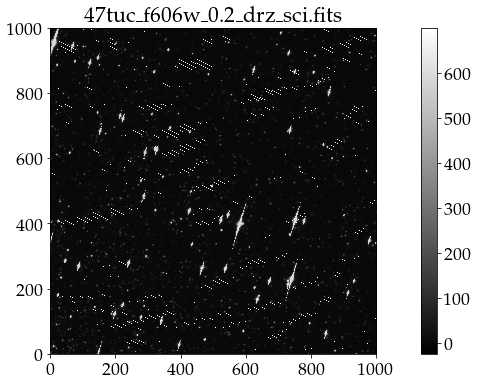

In [17]:
from astropy.visualization import ManualInterval

fig = plt.figure(figsize=(16, 6))

ax1 = fig.add_subplot(1, 1, 1)

# Check if the CTE corrected file exists. If not,
# use the uncorrected file.
if os.path.exists('47tuc_f606w_0.2_drc_sci.fits'):
    driz_02 = '47tuc_f606w_0.2_drc_sci.fits'
else:
    driz_02 = '47tuc_f606w_0.2_drz_sci.fits'

plot_image(driz_02, ax1, fig, origin_y=5000, 
           origin_x=5000, ysize=1000, xsize=1000, extension=0,
           scale=ManualInterval())

# 5. Conclusion

The final image `47tuc_f606w_XX_drz_sci.fits` (or `47tuc_f606w_XX_drc_sci.fits` if the CTE correction was performed) is now ready for scientific analysis. All of the necessarily calibration steps have been performed, cosmic rays and geometric distortion have been removed, and the image has units of electrons/second. For users who choose not to use the pixel-based CTE correction in `calacs`, you must apply the empirical CTE correction equations to your aperture photometry. This information can be found on the [ACS website](http://www.stsci.edu/hst/acs). 

The final mosaic made at the end of this example is available for download for use in other examples, therefore you do not need to keep a copy of it. To free up disk space on your machine, you can run the code block below to delete the files made as part of this example. If you altered any part of this example, you may need to delete additional files yourself.